<a href="https://colab.research.google.com/github/cimple-chandu/cimple-chandu/blob/main/coffee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

libraries


In [1]:
import numpy as np
import pandas as pd
from keras.layers import Input
from keras.models import Model

import matplotlib.pyplot as plt
import cv2
from os import listdir
from os.path import join, isfile
import keras
from PIL import Image
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten,Activation
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.layers import Input, GlobalAveragePooling2D, concatenate, AveragePooling2D
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.decomposition import PCA

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
"""#Data Augmentation"""

default_image_size = tuple((224, 224))
directory_root = '/content/drive/MyDrive/coffee1'



# horizontal flip
def hflip(image_dir):
  image = cv2.imread(image_dir)
  image = cv2.flip(image, 0)
  return convert_image_to_array(image)

# vertical flip
def vflip(image_dir):
  image = cv2.imread(image_dir)
  image = cv2.flip(image, 1)
  return convert_image_to_array(image)

# histogram equalization function
def hist(img):
  img_to_yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
  img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0])
  hist_equalization_result = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
  return hist_equalization_result

#gaussian blurring
from scipy import ndimage
def gaussian(img):
  img = ndimage.gaussian_filter(img, sigma= 5.11)
  return img

# function for rotation
import random
def rotation(img):
  img = cv2.imread(img)
  rows,cols = img.shape[0],img.shape[1]
  randDeg = random.randint(-180, 180)
  matrix = cv2.getRotationMatrix2D((cols/2, rows/2), randDeg, 0.70)
  rotated = cv2.warpAffine(img, matrix, (rows, cols), borderMode=cv2.BORDER_CONSTANT)
  return convert_image_to_array(rotated)

def convert_image_to_array(image_dir):
    try:
        if type(image_dir) is str :
            image = cv2.imread(image_dir)
        else :
            image = image_dir
        if image is not None :
            image = gaussian(image)
            image = hist(image)
            image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

"""#Load Dataset"""

image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)

    for plant_folder in root_dir :
        plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}")

        for image in plant_disease_image_list:
            image_directory = f"{directory_root}/{plant_folder}/{image}"
            image_list.append(convert_image_to_array(image_directory))
            label_list.append(plant_folder)
            image_list.append(hflip(image_directory))
            label_list.append(plant_folder)
            image_list.append(vflip(image_directory))
            label_list.append(plant_folder)
            image_list.append(rotation(image_directory))
            label_list.append(plant_folder)
    print("[INFO] Image loading completed")
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Image loading completed


In [4]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
n_classes = len(label_binarizer.classes_)

len(image_list)

np_image_list = np.array(image_list, dtype=np.float16) / 225.0

from sklearn.model_selection import train_test_split
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.33, random_state = 42)

from keras.utils import to_categorical
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)


print("X_train shape : ",x_train.shape)
print("y_train shape : ",y_train.shape)
print("X_test shape : ",x_test.shape)
print("y_test shape : ",y_test.shape)

[INFO] Spliting data to train, test
X_train shape :  (726, 224, 224, 1)
y_train shape :  (726, 2)
X_test shape :  (358, 224, 224, 1)
y_test shape :  (358, 2)


preprocessing


In [5]:

def conv_layer(conv_x, filters):
    conv_x = BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
    conv_x = Conv2D(filters, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(conv_x)
    conv_x = Dropout(0.2)(conv_x)
    return conv_x


def dense_block(block_x, filters, growth_rate, layers_in_block):
    for i in range(layers_in_block):
        each_layer = conv_layer(block_x, growth_rate)
        block_x = concatenate([block_x, each_layer], axis=-1)
        filters += growth_rate

    return block_x, filters


def transition_block(trans_x, tran_filters):
    trans_x = BatchNormalization()(trans_x)
    trans_x = Activation('relu')(trans_x)
    trans_x = Conv2D(tran_filters, (1, 1), kernel_initializer='he_uniform', padding='same', use_bias=False)(trans_x)
    trans_x = AveragePooling2D((2, 2), strides=(2, 2))(trans_x)

    return trans_x, tran_filters


def dense_net(filters, growth_rate, classes, dense_block_size, layers_in_block):
    input_img = Input(shape=(224, 224, 1))
    x = Conv2D(24, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(input_img)

    dense_x = BatchNormalization()(x)
    dense_x = Activation('relu')(x)

    dense_x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='feature_layer')(dense_x)
    for block in range(dense_block_size - 1):
        dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
        dense_x, filters = transition_block(dense_x, filters)

    dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
    dense_x = BatchNormalization()(dense_x)
    dense_x = Activation('relu')(dense_x)
    dense_x = GlobalAveragePooling2D()(dense_x)

    output = Dense(classes, activation='softmax')(dense_x)

    return Model(input_img, output)

def densenet():
  dense_block_size = 1
  layers_in_block = 4

  growth_rate = 12
  classes = 2
  model = dense_net(growth_rate * 2, growth_rate, classes, dense_block_size, layers_in_block)
  return model

"""**Convolution Neural Network**"""

def cnn():
  model = Sequential()
  depth=1
  height=224
  width=224
  inputShape = (height, width, depth)
  chanDim = -1
  if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
      chanDim = 1
  print(inputShape)
  model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=chanDim))
  model.add(MaxPooling2D(pool_size=(3, 3)))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=chanDim))
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=chanDim))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Conv2D(128, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=chanDim))
  model.add(Conv2D(128, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=chanDim))
  model.add(MaxPooling2D(pool_size=(2, 2),name='feature_layer'))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(1024))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(n_classes))
  model.add(Activation("softmax"))
  return model

In [6]:
"""**ResNet**"""
from keras.initializers import glorot_normal

initializer = glorot_normal()

"""
Creates Residual Network with 50 layers
"""
from keras import layers
from keras.models import Model
from keras.optimizers import Adam

"""
Convolutional Block of ResNet
"""
def convolutional_block(X, f, filters, stage, block, s=2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    # First component of main path
    X = layers.Conv2D(F1, (1, 1), strides=(s, s), name=conv_name_base + '2a',
                            padding='same', kernel_initializer=initializer)(X)
    X = layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = layers.Activation('relu')(X)
    X = layers.Dropout(0.5)(X)

    # Second component of main path
    X = layers.Conv2D(F2, (f, f), strides=(1, 1), name=conv_name_base + '2b',
                            padding='same', kernel_initializer=initializer)(X)
    X = layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = layers.Activation('relu')(X)
    X = layers.Dropout(0.5)(X)

    # Third component of main path
    X = layers.Conv2D(F3, (1, 1), strides=(1, 1), name=conv_name_base + '2c',
                            padding='same', kernel_initializer=initializer)(X)
    X = layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = layers.Conv2D(F3, (1, 1), strides=(s,s), name=conv_name_base + '1',
                                    padding='same', kernel_initializer=initializer)(X_shortcut)
    X_shortcut = layers.BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Add shortcut value to main path, and pass it through a RELU activation
    X = layers.Add()([X, X_shortcut])
    X = layers.Activation('relu')(X)

    return X


def resnet(input_shape=(224, 224, 1), classes=2):
    # Define the input as a tensor with shape input_shape

    from keras import layers
    from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input
    X_input = layers.Input(input_shape)



    # Zero-Padding
    X = layers.ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = layers.Conv2D(64, (7, 7), strides=(2, 2), name='conv1',
                            kernel_initializer=initializer)(X)
    X = layers.BatchNormalization(axis=3, name='bn_conv1')(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL
    X = layers.AveragePooling2D(pool_size=(2, 2),name='feature_layer')(X)

    # output layer
    X = layers.Flatten()(X)
    X = layers.Dense(classes, activation='softmax', name='fc{}'
                            .format(classes), kernel_initializer=initializer)(X)

    # Create model
    model = keras.models.Model(inputs=X_input, outputs=X, name='resnet50')

    return model

In [7]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. You'll need this later to add back to the main path.
    X_shortcut = X

    # First component of main path
    X = layers.Conv2D(filters=F1, kernel_size=(1, 1), strides=(1,1), padding='same',
                            name=conv_name_base + '2a', kernel_initializer=initializer)(X)
    X = layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = layers.Activation('relu')(X)
    X = layers.Dropout(0.5)(X)

    # Second component of main path
    X = layers.Conv2D(filters=F2, kernel_size=(f, f), strides=(1,1), padding='same',
                            name=conv_name_base + '2b', kernel_initializer=initializer)(X)
    X = layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = layers.Activation('relu')(X)
    X = layers.Dropout(0.5)(X)

    # Third component of main path
    X = layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(1,1), padding='same',
                            name=conv_name_base + '2c', kernel_initializer=initializer)(X)
    X = layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Add shortcut value to main path, and pass it through a RELU activation
    X = layers.Add()([X, X_shortcut])
    X = layers.Activation('relu')(X)

    return X

In [10]:
def sum(model):
  model.summary()

def comp(model):
    from keras.optimizers import Adam
    # Initialize Adam with learning_rate
    opt = Adam(learning_rate=0.001)
    # Compile the model using the initialized optimizer
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

"""def fitmodel(model):
  hist=model.fit(x_train,y_train, epochs=16, batch_size=32, shuffle=True,
                    validation_data=(x_test, y_test), validation_steps=16)
  return hist"""

def fitmodel(model):
    history = model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), batch_size=32)
    return history


"""#Define Performance Metrics for DL models"""

def performance(model):
  print("[INFO] Calculating model accuracy")
  scores = model.evaluate(x_test, y_test)
  print(f"Test Accuracy: {scores[1]*100}")
  scores = model.evaluate(x_test, y_test)
  print(f"Train Accuracy: {model.evaluate(x_train,y_train)[1]*100}")

def graph(hist):
  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  epochs = range(1, len(acc) + 1)
  #Train and validation accuracy
  plt.plot(epochs, acc, 'b', label='Training accurarcy')
  plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
  plt.title('Training and Validation accurarcy')
  plt.legend()
  plt.figure()
  #Train and validation loss
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and Validation loss')
  plt.legend()
  plt.show()






In [12]:
"""**CNN**"""

model_cnn=cnn()
sum(model_cnn)
comp(model_cnn)
hist_cnn=fitmodel(model_cnn)
performance(model_cnn)
#graph(hist_cnn)


(224, 224, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 224, 224, 32)      320       
                                                                 
 activation_20 (Activation)  (None, 224, 224, 32)      0         
                                                                 
 batch_normalization_18 (Ba  (None, 224, 224, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 74, 74, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 74, 

23/23 [==============================] - 20s 776ms/step - loss: 1.3788 - accuracy: 0.5496 - val_loss: 3.1403 - val_accuracy: 0.7933
Epoch 2/16
23/23 [==============================] - 16s 687ms/step - loss: 0.7104 - accuracy: 0.6983
Epoch 3/16
23/23 [==============================] - 16s 688ms/step - loss: 0.5935 - accuracy: 0.7479
Epoch 4/16
23/23 [==============================] - 16s 686ms/step - loss: 0.5008 - accuracy: 0.7920
Epoch 5/16
23/23 [==============================] - 16s 686ms/step - loss: 0.4407 - accuracy: 0.8030
Epoch 6/16
23/23 [==============================] - 16s 691ms/step - loss: 0.4495 - accuracy: 0.8223
Epoch 7/16
23/23 [==============================] - 16s 680ms/step - loss: 0.3048 - accuracy: 0.8815
Epoch 8/16
23/23 [==============================] - 16s 697ms/step - loss: 0.2852 - accuracy: 0.8939
Epoch 9/16
23/23 [==============================] - 16s 687ms/step - loss: 0.2859 - accuracy: 0.8760
Epoch 10/16
23/23 [==============================] - 16s 687

In [13]:
import joblib

# Assuming `model` is your trained model
joblib.dump(model_cnn, '/content/drive/My Drive/model_cnn.pkl')  # This will overwrite any existing file at that path.


['/content/drive/My Drive/model_cnn.pkl']

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 224, 224, 24)         216       ['input_2[0][0]']             
                                                                                                  
 activation_27 (Activation)  (None, 224, 224, 24)         0         ['conv2d_20[0][0]']           
                                                                                                  
 feature_layer (MaxPooling2  (None, 112, 112, 24)         0         ['activation_27[0][0]']       
 D)                                                                                         

23/23 [==============================] - 29s 1s/step - loss: 0.5580 - accuracy: 0.7603 - val_loss: 0.5157 - val_accuracy: 0.7933
Epoch 2/16
23/23 [==============================] - 24s 1s/step - loss: 0.5359 - accuracy: 0.7603
Epoch 3/16
23/23 [==============================] - 25s 1s/step - loss: 0.5262 - accuracy: 0.7603
Epoch 4/16
23/23 [==============================] - 25s 1s/step - loss: 0.5209 - accuracy: 0.7603
Epoch 5/16
23/23 [==============================] - 24s 1s/step - loss: 0.5171 - accuracy: 0.7603
Epoch 6/16
23/23 [==============================] - 25s 1s/step - loss: 0.5117 - accuracy: 0.7603
Epoch 7/16
23/23 [==============================] - 24s 1s/step - loss: 0.5083 - accuracy: 0.7603
Epoch 8/16
23/23 [==============================] - 24s 1s/step - loss: 0.5047 - accuracy: 0.7603
Epoch 9/16
23/23 [==============================] - 25s 1s/step - loss: 0.5079 - accuracy: 0.7713
Epoch 10/16
23/23 [==============================] - 24s 1s/step - loss: 0.5076 - accur

ValueError: x and y must have same first dimension, but have shapes (16,) and (1,)

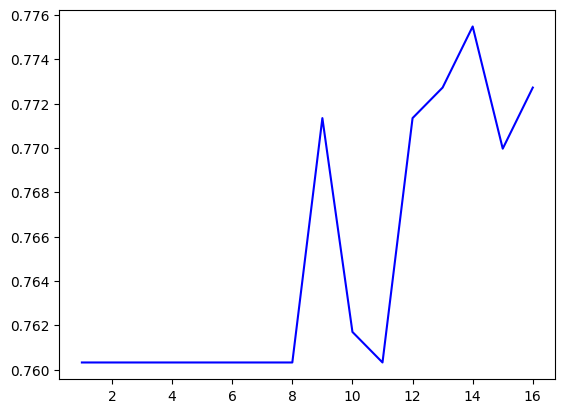

In [14]:
"""dense net"""
model_densenet=densenet()
sum(model_densenet)
comp(model_densenet)
hist_densenet=fitmodel(model_densenet)
performance(model_densenet)
graph(hist_densenet)


In [15]:
import joblib

# Assuming `model` is your trained model
joblib.dump(model_densenet, '/content/drive/My Drive/model_densenet.pkl')  # This will overwrite any existing file at that path.


['/content/drive/My Drive/model_densenet.pkl']

In [16]:
"""**ResNet**"""

model_resnet=resnet()
sum(model_resnet)
comp(model_resnet)
hist_resnet=fitmodel(model_resnet)
performance(model_resnet)
#graph(hist_resnet)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 1)          0         ['input_3[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 64)         3200      ['zero_padding2d[0][0]']      
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1[0][0]']        

23/23 [==============================] - 70s 2s/step - loss: 3.1985 - accuracy: 0.6543 - val_loss: 0.6574 - val_accuracy: 0.7933
Epoch 2/16
23/23 [==============================] - 45s 2s/step - loss: 1.6976 - accuracy: 0.6777
Epoch 3/16
23/23 [==============================] - 44s 2s/step - loss: 2.0562 - accuracy: 0.6928
Epoch 4/16
23/23 [==============================] - 44s 2s/step - loss: 1.1805 - accuracy: 0.6639
Epoch 5/16
23/23 [==============================] - 44s 2s/step - loss: 0.9543 - accuracy: 0.7300
Epoch 6/16
23/23 [==============================] - 44s 2s/step - loss: 0.6372 - accuracy: 0.7507
Epoch 7/16
23/23 [==============================] - 44s 2s/step - loss: 0.6139 - accuracy: 0.7548
Epoch 8/16
23/23 [==============================] - 44s 2s/step - loss: 0.7152 - accuracy: 0.7521
Epoch 9/16
23/23 [==============================] - 44s 2s/step - loss: 1.0067 - accuracy: 0.7452
Epoch 10/16
23/23 [==============================] - 44s 2s/step - loss: 0.9868 - accur

In [17]:
import joblib

# Assuming `model` is your trained model
joblib.dump(model_resnet, '/content/drive/My Drive/model_resnet.pkl')  # This will overwrite any existing file at that path.


['/content/drive/My Drive/model_resnet.pkl']

In [18]:
model_densenet.save("densenet.h5")
model_cnn.save("cnn.h5")
model_resnet.save("resnet.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
model_densenet=keras.models.load_model("densenet.h5")
model_cnn=keras.models.load_model("cnn.h5")
model_resnet=keras.models.load_model("resnet.h5")

In [20]:
'''
def extract(model,x_train,x_test,y_train,y_test,layer):
  new_model=Model(inputs=model.input,outputs=model.get_layer(layer).output)

  #Let's obtain the Input Representations
  x_train_n=new_model.predict(x_train)
  x_test_n=new_model.predict(x_test)

  #Convert back the labels
  y_train_n=[ np.where(r==1)[0][0] for r in y_train ]
  y_test_n=[ np.where(r==1)[0][0] for r in y_test ]
  features=x_train_n.shape[1]*x_train_n.shape[2]*x_train_n.shape[3]
  x_train_new = np.reshape(x_train_n, (-1, features))
  x_test_new = np.reshape(x_test_n, (-1, features))

  x_train=x_train_new
  x_test=x_test_new
  y_train=y_train_n
  y_test=y_test_n

  return x_train,x_test,y_train,y_test

"""#Feature Extraction from DL models

# For DenseNet"""
x_train_densenet, x_test_densenet, y_train_densenet, y_test_densenet = extract(model_densenet, x_train, x_test, y_train, y_test, 'global_average_pooling2d_2')

# For CNN
x_train_cnn, x_test_cnn, y_train_cnn, y_test_cnn = extract(model_cnn, x_train, x_test, y_train, y_test, 'feature_layer')

# For ResNet
x_train_resnet, x_test_resnet, y_train_resnet, y_test_resnet = extract(model_resnet, x_train, x_test, y_train, y_test, 'feature_layer')

'''
def extract(model, x_train, x_test, y_train, y_test, layer):
    new_model = Model(inputs=model.input, outputs=model.get_layer(layer).output)

    # Obtain the Input Representations
    x_train_n = new_model.predict(x_train)
    x_test_n = new_model.predict(x_test)

    # Check output shapes
    print("x_train_n shape:", x_train_n.shape)
    print("x_test_n shape:", x_test_n.shape)

    # Convert back the labels
    y_train_n = [np.where(r == 1)[0][0] for r in y_train]
    y_test_n = [np.where(r == 1)[0][0] for r in y_test]

    # Reshape according to the output dimensions
    if len(x_train_n.shape) == 2:  # Handle 2D output (e.g., (samples, features))
        x_train_new = x_train_n  # No reshape needed if already 2D
        x_test_new = x_test_n
    elif len(x_train_n.shape) == 4:  # Handle 4D output
        features = x_train_n.shape[1] * x_train_n.shape[2] * x_train_n.shape[3]
        x_train_new = np.reshape(x_train_n, (-1, features))
        x_test_new = np.reshape(x_test_n, (-1, features))
    else:
        raise ValueError("Unexpected output shape from the layer.")

    return x_train_new, x_test_new, y_train_n, y_test_n


In [27]:
# For DenseNet"""
x_train_densenet, x_test_densenet, y_train_densenet, y_test_densenet = extract(model_densenet, x_train, x_test, y_train, y_test, 'global_average_pooling2d_1')



12/12 [==============================] - 2s 153ms/step
x_train_n shape: (726, 72)
x_test_n shape: (358, 72)


In [22]:
# For CNN
x_train_cnn, x_test_cnn, y_train_cnn, y_test_cnn = extract(model_cnn, x_train, x_test, y_train, y_test, 'feature_layer')


12/12 [==============================] - 1s 97ms/step
x_train_n shape: (726, 18, 18, 128)
x_test_n shape: (358, 18, 18, 128)


In [23]:

# For ResNet
x_train_resnet, x_test_resnet, y_train_resnet, y_test_resnet = extract(model_resnet, x_train, x_test, y_train, y_test, 'feature_layer')

12/12 [==============================] - 5s 421ms/step
x_train_n shape: (726, 3, 3, 2048)
x_test_n shape: (358, 3, 3, 2048)


In [28]:
'''def pca(x_train,x_test,model):
  if model=='densenet':
    components=361
  elif model=='cnn':
    components=256
  elif model=='vgg16':
    components=256

  pca_model = PCA(n_components=components)
  pca_model.fit(x_train)
  train_images_reduced = pca_model.transform(x_train)
  test_images_reduced = pca_model.transform(x_test)

  # verify shape after PCA
  print("Train images shape:", train_images_reduced.shape)
  print("Test images shape:", test_images_reduced.shape)

  # get exact variability retained
  print("\nVar retained (%):",
        np.sum(pca_model.explained_variance_ratio_ * 100))

  x_train=train_images_reduced
  x_test=test_images_reduced

  return x_train,x_test'''
"""def pca(x_train, x_test, model):
    # Determine components based on model or shape of data
    if model == 'densenet':
        components = min(x_train.shape[0], x_train.shape[1], 361)  # Adjust based on shape
    elif model == 'cnn':
        components = min(x_train.shape[0], x_train.shape[1], 256)
    elif model == 'resnet':
        components = min(x_train.shape[0], x_train.shape[1], 256)

    # Apply PCA
    pca_model = PCA(n_components=components)
    pca_model.fit(x_train)
    train_images_reduced = pca_model.transform(x_train)
    test_images_reduced = pca_model.transform(x_test)

    # Check variability retained
    print("Train images shape:", train_images_reduced.shape)
    print("Test images shape:", test_images_reduced.shape)
    print("\nVar retained (%):", np.sum(pca_model.explained_variance_ratio_ * 100))

    return train_images_reduced, test_images_reduced"""
import numpy as np
from sklearn.decomposition import PCA

def pca(x_train, x_test, model):
    # Determine the number of components based on the model type
    if model == 'densenet':
        components = min(x_train.shape[0], x_train.shape[1], 72)  # Adjust to 72 features as per your requirement
    elif model == 'cnn':
        components = min(x_train.shape[0], x_train.shape[1], 256)
    elif model == 'resnet':
        components = min(x_train.shape[0], x_train.shape[1], 256)
    else:
        raise ValueError("Unknown model type specified")

    # Apply PCA
    pca_model = PCA(n_components=components)
    pca_model.fit(x_train)  # Fit PCA on the training data

    # Transform the datasets
    train_images_reduced = pca_model.transform(x_train)
    test_images_reduced = pca_model.transform(x_test)

    # Check variability retained
    print("Train images shape:", train_images_reduced.shape)
    print("Test images shape:", test_images_reduced.shape)
    print("\nVariance retained (%):", np.sum(pca_model.explained_variance_ratio_ * 100))

    return train_images_reduced, test_images_reduced






In [29]:

# For DenseNet
x_train_red_densenet, x_test_red_densenet = pca(x_train_densenet, x_test_densenet, "densenet")

Train images shape: (726, 72)
Test images shape: (358, 72)

Variance retained (%): 100.000015


In [30]:
# For CNN
x_train_red_cnn, x_test_red_cnn = pca(x_train_cnn, x_test_cnn, "cnn")



Train images shape: (726, 256)
Test images shape: (358, 256)

Variance retained (%): 95.37291


In [31]:
# For ResNet
x_train_red_resnet, x_test_red_resnet = pca(x_train_resnet, x_test_resnet, "resnet")  # Replace with 'resnet' if needed

Train images shape: (726, 256)
Test images shape: (358, 256)

Variance retained (%): 99.3041


In [32]:
"""x_train_red_densenet,x_test_red_densenet=pca(x_train_densenet,x_test_densenet,densenet)



x_train_red_cnn,x_test_red_cnn=pca(x_train_cnn,x_test_cnn,cnn)



x_train_red_resnet,x_test_red_resnet=pca(x_train_resnet,x_test_resnet,resnet)

"""

def display_metrics(a,b):
  conf_matrix = confusion_matrix(a,b)
  FP = conf_matrix[0,1]
  FN = conf_matrix[1,0]
  TP = conf_matrix[0,0]
  TN = conf_matrix[1,1]

  # Sensitivity, hit rate, recall, or true positive rate
  print("Recall/ Sensitivity: ",TP/(TP+FN))
  # Specificity or true negative rate
  print("Specificity: ",TN/(TN+FP))
  # Precision or positive predictive value
  print("Precision: ",TP/(TP+FP))
  # Fall out or false positive rate
  print("False positive rate: ",FP/(FP+TN))
  # Overall accuracy
  print("Accuracy: ",(TP+TN)/(TP+FP+FN+TN) *100)
  print("Classification Report: ")
  print(classification_report(a,b))

In [33]:


"""#Define Machine Learning classifiers

**K-Nearest Neighbor**
"""

def knn_ml(x_train,x_test,y_train,y_test):
  from sklearn.neighbors import KNeighborsClassifier
  knc=KNeighborsClassifier()
  knc.fit(x_train,y_train)
  knc.score(x_train,y_train)
  knn_y_pred=knc.predict(x_test)
  knn_x_pred=knc.predict(x_train)

  from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
  print("Training Data : ")
  display_metrics(y_train,knn_x_pred)
  print("Testing Data : ")
  display_metrics(y_test,knn_y_pred)

  return knc

"""**Support Vector Machine**"""

def svm_ml(x_train,x_test,y_train,y_test):
  from sklearn.svm import SVC
  svm = SVC(kernel='linear')
  svm.fit(x_train, y_train)
  svm_y_pred = svm.predict(x_test)
  svm_x_pred = svm.predict(x_train)

  from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
  print("Training Data : ")
  display_metrics(y_train,svm_x_pred)
  print("Testing Data : ")
  display_metrics(y_test,svm_y_pred)

  return svm

"""**Naive Bayes**"""

def naivebayes_ml(x_train,x_test,y_train,y_test):
  from sklearn.naive_bayes import GaussianNB
  nb = GaussianNB()
  nb.fit(x_train, y_train)
  nb_y_pred=nb.predict(x_test)
  nb_x_pred=nb.predict(x_train)

  from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
  print("Training Data : ")
  display_metrics(y_train,nb_x_pred)
  print("Testing Data : ")
  display_metrics(y_test,nb_y_pred)

  return nb

"""**Logistic Regression**"""

def logreg_ml(x_train,x_test,y_train,y_test):
  from sklearn.linear_model import LogisticRegression
  lr = LogisticRegression(solver='saga')
  lr.fit(x_train, y_train)
  lr_y_pred=lr.predict(x_test)
  lr_x_pred=lr.predict(x_train)

  from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
  print("Training Data : ")
  display_metrics(y_train,lr_x_pred)
  print("Testing Data : ")
  display_metrics(y_test,lr_y_pred)

  return lr

"""#Evaluate ML classifiers using DL extracted, reduced features

**DenseNet**
"""

densenet_knn = knn_ml(x_train_red_densenet,x_test_red_densenet,y_train_densenet,y_test_densenet)

densenet_svm = svm_ml(x_train_red_densenet,x_test_red_densenet,y_train_densenet,y_test_densenet)

densenet_nb = naivebayes_ml(x_train_red_densenet,x_test_red_densenet,y_train_densenet,y_test_densenet)

densenet_lr = logreg_ml(x_train_red_densenet,x_test_red_densenet,y_train_densenet,y_test_densenet)

"""**CNN**"""

cnn_knn = knn_ml(x_train_red_cnn,x_test_red_cnn,y_train_cnn,y_test_cnn)

cnn_svm = svm_ml(x_train_red_cnn,x_test_red_cnn,y_train_cnn,y_test_cnn)

cnn_nb = naivebayes_ml(x_train_red_cnn,x_test_red_cnn,y_train_cnn,y_test_cnn)

cnn_lr = logreg_ml(x_train_red_cnn,x_test_red_cnn,y_train_cnn,y_test_cnn)

"""**Resnet**"""

resnet_knn = knn_ml(x_train_red_resnet,x_test_red_resnet,y_train_resnet,y_test_resnet)

resnet_svm = svm_ml(x_train_red_resnet,x_test_red_resnet,y_train_resnet,y_test_resnet)

resnet_nb = naivebayes_ml(x_train_red_resnet,x_test_red_resnet,y_train_resnet,y_test_resnet)

resnet_lr = logreg_ml(x_train_red_resnet,x_test_red_resnet,y_train_resnet,y_test_resnet)

"""#Graphical User Interface"""





Training Data : 
Recall/ Sensitivity:  0.8656716417910447
Specificity:  0.7560975609756098
Precision:  0.9456521739130435
False positive rate:  0.24390243902439024
Accuracy:  84.71074380165288
Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.95      0.90       552
           1       0.76      0.53      0.63       174

    accuracy                           0.85       726
   macro avg       0.81      0.74      0.77       726
weighted avg       0.84      0.85      0.84       726

Testing Data : 
Recall/ Sensitivity:  0.8344155844155844
Specificity:  0.46
Precision:  0.9049295774647887
False positive rate:  0.54
Accuracy:  78.2122905027933
Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.90      0.87       284
           1       0.46      0.31      0.37        74

    accuracy                           0.78       358
   macro avg       0.65      0.61      0.62       35

<ipython-input-32-37c5e1d8e47e>:23: RuntimeWarning: invalid value encountered in scalar divide
  print("Specificity: ",TN/(TN+FP))
<ipython-input-32-37c5e1d8e47e>:27: RuntimeWarning: invalid value encountered in scalar divide
  print("False positive rate: ",FP/(FP+TN))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetric

Training Data : 
Recall/ Sensitivity:  0.8202416918429003
Specificity:  0.859375
Precision:  0.9836956521739131
False positive rate:  0.140625
Accuracy:  82.36914600550963
Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.98      0.89       552
           1       0.86      0.32      0.46       174

    accuracy                           0.82       726
   macro avg       0.84      0.65      0.68       726
weighted avg       0.83      0.82      0.79       726

Testing Data : 
Recall/ Sensitivity:  0.8128654970760234
Specificity:  0.625
Precision:  0.9788732394366197
False positive rate:  0.375
Accuracy:  80.44692737430168
Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.98      0.89       284
           1       0.62      0.14      0.22        74

    accuracy                           0.80       358
   macro avg       0.72      0.56      0.56       358
weighted avg    

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Training Data : 
Recall/ Sensitivity:  0.974903474903475
Specificity:  0.7740384615384616
Precision:  0.9148550724637681
False positive rate:  0.22596153846153846
Accuracy:  91.73553719008265
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       552
           1       0.77      0.93      0.84       174

    accuracy                           0.92       726
   macro avg       0.87      0.92      0.89       726
weighted avg       0.93      0.92      0.92       726

Testing Data : 
Recall/ Sensitivity:  0.864
Specificity:  0.37037037037037035
Precision:  0.7605633802816901
False positive rate:  0.6296296296296297
Accuracy:  71.50837988826815
Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.76      0.81       284
           1       0.37      0.54      0.44        74

    accuracy                           0.72       358
   macro avg       0.62      0.65   

<ipython-input-32-37c5e1d8e47e>:23: RuntimeWarning: invalid value encountered in scalar divide
  print("Specificity: ",TN/(TN+FP))
<ipython-input-32-37c5e1d8e47e>:27: RuntimeWarning: invalid value encountered in scalar divide
  print("False positive rate: ",FP/(FP+TN))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetric

'#Graphical User Interface'

In [34]:
!pip install gradio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/1

In [35]:
"""import cv2
import gradio as gr
x_train_reshaped = x_train.reshape(-1, 224 * 224 * 1)

# Define and fit PCA model

def densenet_svm_gui(image):
    image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, default_image_size)
    l=[]
    l.append(img_to_array(image))
    l = np.array(l, dtype=np.float16) / 225.0
    data=np.reshape(l,(-1,224*224*1))
    result=densenet_svm.predict(data)
    if result==0:
        result="Healthy"
    else:
        result="Unhealthy"
    return result

#built interface with gradio to test the function
gr.Interface(fn=densenet_svm_gui, inputs="image", outputs="text",title='Densenet Model',allow_flagging="never").launch(debug=True);"""
import cv2
import gradio as gr
import numpy as np
from keras.preprocessing.image import img_to_array
from sklearn.decomposition import PCA

# Assuming x_train is already defined and preprocessed
x_train_reshaped = x_train.reshape(-1, 224 * 224 * 1)

# Define and fit PCA model
pca_model = PCA(n_components=72)
pca_model.fit(x_train_reshaped)

def densenet_svm_gui(image):
    # Convert image to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Resize image to default size
    image = cv2.resize(image, (224, 224))
    # Convert to array and normalize
    l = []
    l.append(img_to_array(image))
    l = np.array(l, dtype=np.float16) / 255.0  # Normalize to [0, 1]

    # Reshape the image to match the PCA model expectations
    data = np.reshape(l, (-1, 224 * 224 * 1))

    # Apply PCA to reduce to the expected number of features (72)
    data = pca_model.transform(data)

    # Check the shape of the data after PCA transformation
    print("Shape of data after PCA:", data.shape)

    # Make prediction using the SVM model
    result = densenet_svm.predict(data)
    if result == 1:
        result = "Healthy"
    else:
        result = "Unhealthy"
    return result

# Build interface with Gradio to test the function
gr.Interface(fn=densenet_svm_gui, inputs="image", outputs="text", title='Coffee Leaf Disease Detection', allow_flagging="never").launch(debug=True)





/usr/local/lib/python3.10/dist-packages/gradio/interface.py:393: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://5716e45e6a51e650ce.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Shape of data after PCA: (1, 72)
Shape of data after PCA: (1, 72)
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://5716e45e6a51e650ce.gradio.live
